###Bibliotecas

In [ ]:
!pip install spotipy #biblioteca que acessa API Web do Spotify
!pip install langdetect #detecção de idioma
!pip install transformers torch torchvision torchaudio
!pip install requests beautifulsoup4 unidecode #extrai as letras das musicas com Web Scrapping
!pip install nltk
!pip install legibilidad
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.9/339.9 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 24.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=0d8c0c79ed7a4c5fa73a8c299cefacc5a9366e5f26b11763d735a2f2ef6fbb75
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for legibilidad: filename=legibilidad-0.21-py3-none-any.whl size=8302 sha256=d26884a590a7c847d89912a9fa08fa330cc317dcf8ba46b8faf040b582032f0d
  Stored in directory: /root/.cache/pip/wheels/56/d6/bf/e4f6d55678c1296b0f56a5aa62f81c7d5fb76420cea1759226
Successfully built legibilidad
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 9.2 MB/s eta 0:00:00
   ━

###Acessando a API Web Spotify

In [ ]:
#Bibliotecas para utilizar a API Web do Spotify
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from google.colab import userdata
import pprint

client_id = userdata.get('SPOTIPY_CLIENT_ID')
client_secret = userdata.get('SPOTIPY_CLIENT_SECRET')

auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [ ]:
lista_generos_principais = [
  'funk',
  'pop',
  'mpb',
  'pagode',
  'samba',
  'rap',
  'hip hop',
  'forró',
  'arrocha',
  'rock',
  'axé',
  'piseiro',
  'sertanejo',
  'classical',
  'choral',
  'lo-fi'
]

def escolher_genero_principal(lista_de_generos_str):
  """
  Verifica uma string de gêneros e retorna o primeiro que encontrar
  na nossa lista de prioridades.
  """
  # Lida com casos onde o gênero pode não ser uma string
  if not isinstance(lista_de_generos_str, str):
    return 'Indefinido'

  # Itera sobre a lista de prioridades
  for genero_principal in lista_generos_principais:
    # Verifica se o gênero principal está contido na string de gêneros do artista
    if genero_principal in lista_de_generos_str:
      return genero_principal # Retorna o primeiro que encontrar

  # Se, após o loop, nenhum gênero da nossa lista for encontrado, pega o primeiro da lista
  return lista_de_generos_str.split(',')[0].strip()

###Extração dos Dados das Playlists

In [ ]:
#Bibliotecas para trabalhar com Data Frame
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:

  #URI ou ID da playlist
  playlist_uri = 'spotify:playlist:79tyajkNegwnty1G4W2HDh'

  # A API do Spotify retorna no máximo 100 faixas por vez (paginação)
  # Este código busca todas as faixas, mesmo em playlists com mais de 100 músicas.

  offset = 0
  all_tracks = []
  artist_ids = set()

  while True:
    # Pega um lote de 100 músicas
    response = sp.playlist_tracks(playlist_uri,
                                  offset=offset,
                                  fields='items.track(id,name,album.name,popularity,artists(id,name)),total,next')

    if not response['items']:
      break

    # Itera sobre as músicas do lote e extrai as informações
    for item in response['items']:
      track = item.get('track')
      if track and track.get('id'): # Verifica se a faixa existe e não é nula (músicas removidas)
        track_info = {
          'nome_musica': track['name'],
          # Concatena os nomes dos artistas se houver mais de um
          'artistas': ', '.join([artist['name'] for artist in track['artists']]),
          'album': track['album']['name'],
          'popularidade': track['popularity'],
          'id_musica': track['id'],
          'artist_ids': [artist['id'] for artist in track['artists']]
        }
        all_tracks.append(track_info)

        # Adiciona os IDs dos artistas ao nosso set
        for artist in track['artists']:
          artist_ids.add(artist['id'])

    # Se não houver mais páginas de resultados, para o loop
    if response['next'] is None:
      break

    # Aumenta o deslocamento para buscar a próxima página
    offset += 100

  # Procura o genero dos artistas
  artist_list = list(artist_ids)
  artist_genre_map = {} # Dicionário para mapear ID do artista -> seus gêneros

  # A API permite buscar até 50 artistas por vez, logo é necessário dividir em lotes
  for i in range(0, len(artist_list), 50):
    batch_ids = artist_list[i:i+50]
    artists_details = sp.artists(batch_ids)
    for artist in artists_details['artists']:
      artist_genre_map[artist['id']] = artist['genres']

  # Mapeamento dos Gêneros de volta para as Músicas
  for track in all_tracks:
    track_genres = set()
    # Para cada ID de artista na música, pega seus gêneros no nosso mapa
    for artist_id in track['artist_ids']:
      genres = artist_genre_map.get(artist_id, [])
      track_genres.update(genres)

    # Adiciona a coluna de gêneros
    if track_genres:
      track['generos'] = ', '.join(list(track_genres))
    else:
      track['generos'] = 'N/A' # Caso um artista não tenha gênero definido

    # Remove a coluna temporária que guardava os IDs
    del track['artist_ids']

  df_playlist = pd.DataFrame(all_tracks)

  #Limpeza superficial do Dataset
  df_playlist['artista_principal'] = df_playlist['artistas'].str.split(',').str[0].str.strip() #Artista Principal
  df_playlist['nome_musica_limpo'] = df_playlist['nome_musica'].str.replace(r'\s*(-|\(|\[).*', '', regex=True).str.strip() #Musica sem caracteres especiais
  df_playlist['genero_principal'] = df_playlist['generos'].apply(escolher_genero_principal)

  print(f"Total de músicas extraídas: {len(df_playlist)}")
  display(df_playlist)

except Exception as e:
  print(f"Ocorreu um erro: {e}")
  print("Verifique se suas credenciais (SPOTIPY_CLIENT_ID e SPOTIPY_CLIENT_SECRET) estão configuradas corretamente como variáveis de ambiente.")

Total de músicas extraídas: 50


,nome_musica,artistas,album,popularidade,id_musica,generos,artista_principal,nome_musica_limpo,genero_principal
0,Posso Até Não Te Dar Flores,"DJ Japa NK, MC Meno K, MC Ryan SP, Mc Jacaré,...",Posso Até Não Te Dar Flores,86,4G7bbgD2DHORU4frrWoCXp,"brazilian funk, funk carioca, trap funk, funk ...",DJ Japa NK,Posso Até Não Te Dar Flores,funk
1,ME POSTOU NO DAILY - FESTA DO BIG G,"MC GP, Mc Lele JP, DJ DAVI DOGDOG, Dj Andrabeat",ME POSTOU NO DAILY - FESTA DO BIG G,83,4ATO632UaFTJltxCbfBpHI,"brazilian funk, trap funk, funk consciente",MC GP,ME POSTOU NO DAILY,funk
2,P do Pecado - Ao Vivo,"Grupo Menos É Mais, Simone Mendes",MOLHO (Ao Vivo),76,38Ps9Kui6qJjpVqdBOfN5M,"piseiro, pagode, sertanejo, sertanejo universi...",Grupo Menos É Mais,P do Pecado,pagode
3,SEQUÊNCIA FEITICEIRA,"PEDRO SAMPAIO, Mc Gw, Mc Jhey, Mc Rodrigo do C...",SEQUÊNCIA FEITICEIRA,85,4Lwm0XFseZ09OBdmUJlcYp,"brazilian funk, brazilian phonk, brega funk, f...",PEDRO SAMPAIO,SEQUÊNCIA FEITICEIRA,funk
4,Eu Me Apaixonei,Vitinho Imperador,Eu Me Apaixonei,84,4SjcIkVc4cvFgURD1EHxDM,"piseiro, seresta, sertanejo, arrocha, forró, b...",Vitinho Imperador,Eu Me Apaixonei,forró
5,FAMOSINHA,"Dj Caio Vieira, MC Meno K, Mc Rodrigo do CN",FAMOSINHA,84,5Nj2UVsxXAvhfYNpcre3al,"brazilian funk, funk de bh, funk carioca",Dj Caio Vieira,FAMOSINHA,funk
6,Tubarões - Ao Vivo,Diego & Victor Hugo,Ao Vivo Em Uberlândia Vol. 02,79,6tUdNbB9aYbX0sUDXOzX1u,"piseiro, sertanejo, sertanejo universitário, a...",Diego & Victor Hugo,Tubarões,arrocha
7,Deixa Eu - Ao Vivo,Murilo Huff,Acústico (Ao Vivo),83,2Hw0LzrD6ic8AckKBxJhiO,"arrocha, sertanejo, sertanejo universitário, a...",Murilo Huff,Deixa Eu,arrocha
8,Pela Última Vez - Ao Vivo,"Grupo Menos É Mais, NATTAN",MOLHO (Ao Vivo),74,6B7ot6Wlqf7zt3FCkYl2FJ,"piseiro, pagode, seresta, sertanejo, arrocha, ...",Grupo Menos É Mais,Pela Última Vez,pagode
9,Ama Um Maloqueiro,"Rafa e Junior, Hugo & Guilherme, DJ Ari SL",Ama Um Maloqueiro,83,2ejSYn4SfoE07mXPlnYVED,"arrocha, sertanejo, sertanejo universitário, a...",Rafa e Junior,Ama Um Maloqueiro,arrocha


Top 3 no Brasil - 28/10/2025

In [ ]:
df_playlist[['artista_principal', 'nome_musica', 'genero_principal']].head(3)

,artista_principal,nome_musica,genero_principal
0,DJ Japa NK,Posso Até Não Te Dar Flores,funk
1,MC GP,ME POSTOU NO DAILY - FESTA DO BIG G,funk
2,Grupo Menos É Mais,P do Pecado - Ao Vivo,pagode


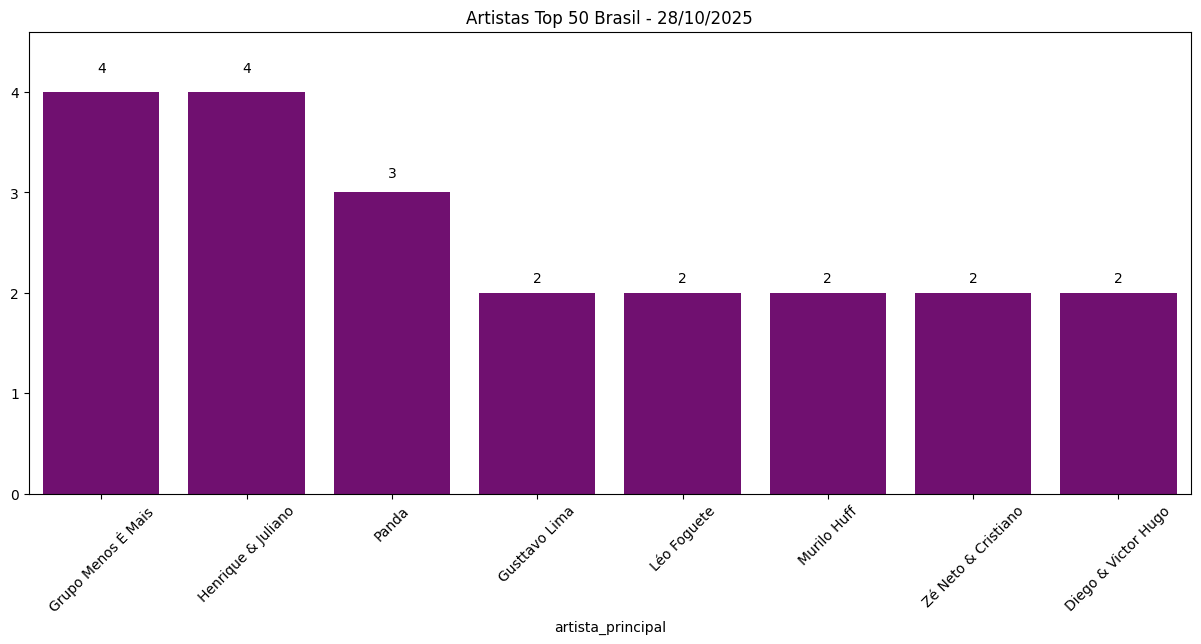

In [ ]:
base = df_playlist.groupby('artista_principal')['id_musica'].count().sort_values(ascending=False).head(8)

plt.figure(figsize=(15,6))
ax = sns.barplot(x=base.index, y=base.values, color="purple")
for p in ax.patches:
  height = p.get_height()
  ax.text(
    x=p.get_x() + p.get_width() / 2.,
    y=height * 1.05,
    s=f'{height:.0f}',
    ha='center'
  )
ax.set_ylim(0, base.values.max() * 1.15)
plt.title('Artistas Top 50 Brasil - 28/10/2025')
plt.xticks(rotation=45)
plt.show()

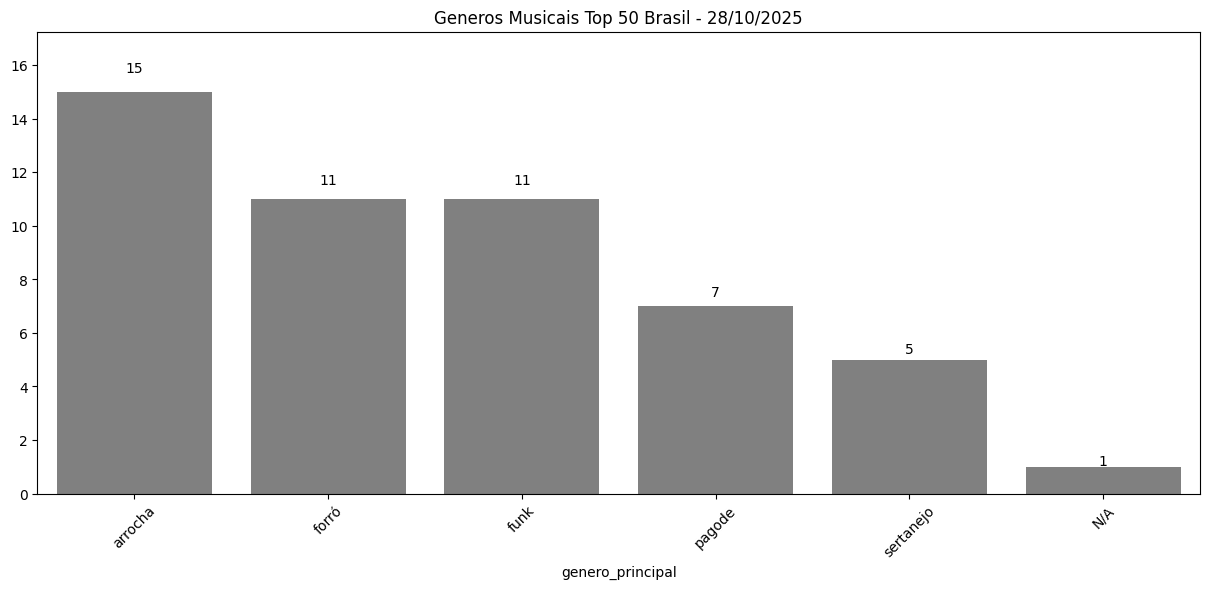

In [ ]:
base = df_playlist.groupby('genero_principal')['id_musica'].count().sort_values(ascending=False).head(8)

plt.figure(figsize=(15,6))
ax = sns.barplot(x=base.index, y=base.values, color="grey")
for p in ax.patches:
  height = p.get_height()
  ax.text(
    x=p.get_x() + p.get_width() / 2.,
    y=height * 1.05,
    s=f'{height:.0f}',
    ha='center'
  )
ax.set_ylim(0, base.values.max() * 1.15)
plt.title('Generos Musicais Top 50 Brasil - 28/10/2025')
plt.xticks(rotation=45)
plt.show()

###Extração de Dados por Artista (Mais Famosas Por País)

In [ ]:

try:
  # URI do artista
  artist_uri = 'spotify:artist:1HY2Jd0NmPuamShAr6KMms'

  # Pega as 10 músicas mais populares do artista no EUA
  response = sp.artist_top_tracks(artist_uri, country='US')

  # Pega as informações do artista para obter os gêneros
  artist_info = sp.artist(artist_uri)
  artist_genres = artist_info.get('genres', ['N/A'])

  all_tracks = []

  for track in response['tracks']:
    if track and track.get('id'): # Verifica se a faixa é válida
      track_info = {
        'nome_musica': track['name'],
        # Concatena os nomes dos artistas
        'artistas': ', '.join([artist['name'] for artist in track['artists']]),
        'album': track['album']['name'],
        'id_musica': track['id'],
        'popularidade': track['popularity'],
        # Adiciona os gêneros do artista principal a todas as suas top músicas
        'generos': ', '.join(artist_genres) if artist_genres else 'N/A'
      }
      all_tracks.append(track_info)

  df_top_musicas = pd.DataFrame(all_tracks)

  df_top_musicas['artista_principal'] = df_top_musicas['artistas'].str.split(',').str[0].str.strip() #Artista Principal
  df_top_musicas['nome_musica_limpo'] = df_top_musicas['nome_musica'].str.replace(r'\s*(-|\(|\[).*', '', regex=True).str.strip() #Musica sem caracteres especiais
  df_top_musicas['genero_principal'] = df_top_musicas['generos'].apply(escolher_genero_principal)

  print(f"Total de músicas extraídas do artista: {len(df_top_musicas)}")
  display(df_top_musicas)

except Exception as e:
  print(f"Ocorreu um erro: {e}")
  print("Verifique se o URI do artista está correto e se suas credenciais são válidas.")

Total de músicas extraídas do artista: 10


,nome_musica,artistas,album,id_musica,popularidade,generos,artista_principal,nome_musica_limpo,genero_principal
0,Die With A Smile,"Lady Gaga, Bruno Mars",MAYHEM,7so0lgd0zP2Sbgs2d7a1SZ,86,"art pop, pop",Lady Gaga,Die With A Smile,pop
1,The Dead Dance,Lady Gaga,MAYHEM,5pobX21I8uZdHM8YOWItU7,80,"art pop, pop",Lady Gaga,The Dead Dance,pop
2,Poker Face,Lady Gaga,The Fame,1QV6tiMFM6fSOKOGLMHYYg,84,"art pop, pop",Lady Gaga,Poker Face,pop
3,Abracadabra,Lady Gaga,MAYHEM,2LHNTC9QZxsL3nWpt8iaSR,81,"art pop, pop",Lady Gaga,Abracadabra,pop
4,Just Dance,"Lady Gaga, Colby O'Donis",The Fame,1dzQoRqT5ucxXVaAhTcT0J,83,"art pop, pop",Lady Gaga,Just Dance,pop
5,Bad Romance,Lady Gaga,The Fame Monster (Deluxe Edition),0SiywuOBRcynK0uKGWdCnn,85,"art pop, pop",Lady Gaga,Bad Romance,pop
6,Shallow,"Lady Gaga, Bradley Cooper",A Star Is Born Soundtrack,2VxeLyX666F8uXCJ0dZF8B,84,"art pop, pop",Lady Gaga,Shallow,pop
7,Always Remember Us This Way,Lady Gaga,A Star Is Born Soundtrack (Without Dialogue),2rbDhOo9Fh61Bbu23T2qCk,84,"art pop, pop",Lady Gaga,Always Remember Us This Way,pop
8,Judas,Lady Gaga,Born This Way (International Special Edition V...,7F25roCtYi55JouckaayPC,81,"art pop, pop",Lady Gaga,Judas,pop
9,Bloody Mary,Lady Gaga,Born This Way (International Special Edition V...,53jnnqFSRGMDB9ADrNriCA,79,"art pop, pop",Lady Gaga,Bloody Mary,pop


###Extração de Dados por Artista (Global)

In [ ]:
try:
  artist_uri = 'spotify:artist:1HY2Jd0NmPuamShAr6KMms'
  num_musicas_desejado = 30

  print("Buscando álbuns e coletâneas do artista...")
  all_albums = []
  offset = 0
  while True:
    response = sp.artist_albums(artist_uri, album_type='album,compilation', offset=offset, limit=50)
    albums = response['items']
    if not albums:
      break
    all_albums.extend(albums)
    offset += 50

  album_ids = {album['id'] for album in all_albums}
  print(f"Encontrados {len(album_ids)} álbuns/coletâneas únicos.")

  print("Coletando IDs de todas as músicas...")
  track_ids = []
  for album_id in album_ids:
    response = sp.album_tracks(album_id, limit=50)
    for track in response['items']:
      track_ids.append(track['id'])

  # Remove IDs duplicados que podem vir de diferentes versões do mesmo álbum
  track_ids = list(set(track_ids))
  print(f"Encontrados {len(track_ids)} IDs de músicas únicas.")

  print("Buscando detalhes completos e popularidade das músicas...")
  all_tracks = []
  for i in range(0, len(track_ids), 50):
    batch_ids = track_ids[i:i+50]
    response = sp.tracks(batch_ids)

    for track in response['tracks']:
      if track: # Garante que a faixa não é nula
        track_info = {
          'nome_musica': track['name'],
          'artistas': ', '.join([artist['name'] for artist in track['artists']]),
          'id_musica': track['id'],
          'popularidade': track['popularity'],
          'album': track['album']['name']
        }
        all_tracks.append(track_info)

  if not all_tracks:
    print("Nenhuma música encontrada.")
  else:
    df_todas_musicas = pd.DataFrame(all_tracks)

    # Lógica de limpeza (continua a mesma e agora funciona como esperado)
    df_todas_musicas['nome_limpo'] = df_todas_musicas['nome_musica'].str.replace(r'\s*(-|\(|\[).*', '', regex=True).str.strip()
    df_todas_musicas.sort_values(by='popularidade', ascending=False, inplace=True)
    df_todas_musicas.drop_duplicates(subset=['nome_limpo'], keep='first', inplace=True)

    df_top_musicas_global = df_todas_musicas.head(num_musicas_desejado)

    # Adicionar Gêneros
    artist_info = sp.artist(artist_uri)
    artist_genres = artist_info.get('genres', ['N/A'])
    df_top_musicas_global['generos'] = ', '.join(artist_genres) if artist_genres else 'N/A'

    print(f"\nExibindo as {num_musicas_desejado} músicas mais populares (com popularidade correta):")

    df_top_musicas_global['artista_principal'] = df_top_musicas_global['artistas'].str.split(',').str[0].str.strip() #Artista Principal
    df_top_musicas_global['nome_musica_limpo'] = df_top_musicas_global['nome_musica'].str.replace(r'\s*(-|\(|\[).*', '', regex=True).str.strip() #Musica sem caracteres especiais
    df_top_musicas_global['genero_principal'] = df_top_musicas_global['generos'].apply(escolher_genero_principal)

    display(df_top_musicas_global)

except Exception as e:
  print(f"Ocorreu um erro: {e}")

Buscando álbuns e coletâneas do artista...
Encontrados 19 álbuns/coletâneas únicos.
Coletando IDs de todas as músicas...
Encontrados 334 IDs de músicas únicas.
Buscando detalhes completos e popularidade das músicas...

Exibindo as 30 músicas mais populares (com popularidade correta):


/tmp/ipython-input-2430547650.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_musicas_global['generos'] = ', '.join(artist_genres) if artist_genres else 'N/A'
/tmp/ipython-input-2430547650.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_musicas_global['artista_principal'] = df_top_musicas_global['artistas'].str.split(',').str[0].str.strip() #Artista Principal
/tmp/ipython-input-2430547650.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

,nome_musica,artistas,id_musica,popularidade,album,nome_limpo,generos,artista_principal,nome_musica_limpo,genero_principal
232,Bad Romance,Lady Gaga,0SiywuOBRcynK0uKGWdCnn,85,The Fame Monster (Deluxe Edition),Bad Romance,"art pop, pop",Lady Gaga,Bad Romance,pop
250,Shallow,"Lady Gaga, Bradley Cooper",2VxeLyX666F8uXCJ0dZF8B,84,A Star Is Born Soundtrack,Shallow,"art pop, pop",Lady Gaga,Shallow,pop
142,Always Remember Us This Way,Lady Gaga,2rbDhOo9Fh61Bbu23T2qCk,84,A Star Is Born Soundtrack (Without Dialogue),Always Remember Us This Way,"art pop, pop",Lady Gaga,Always Remember Us This Way,pop
233,Judas,Lady Gaga,7F25roCtYi55JouckaayPC,81,Born This Way (International Special Edition V...,Judas,"art pop, pop",Lady Gaga,Judas,pop
108,The Dead Dance,Lady Gaga,5pobX21I8uZdHM8YOWItU7,80,MAYHEM,The Dead Dance,"art pop, pop",Lady Gaga,The Dead Dance,pop
268,Bloody Mary,Lady Gaga,53jnnqFSRGMDB9ADrNriCA,79,Born This Way (International Special Edition V...,Bloody Mary,"art pop, pop",Lady Gaga,Bloody Mary,pop
211,Just Dance,"Lady Gaga, Colby O'Donis",2x7MyWybabEz6Y6wvHuwGE,79,The Fame,Just Dance,"art pop, pop",Lady Gaga,Just Dance,pop
186,Poker Face,Lady Gaga,5R8dQOPq8haW94K7mgERlO,79,The Fame,Poker Face,"art pop, pop",Lady Gaga,Poker Face,pop
21,Applause,Lady Gaga,5ka2ajep9OAvU5Sgduhiex,78,ARTPOP,Applause,"art pop, pop",Lady Gaga,Applause,pop
206,Paparazzi,Lady Gaga,7Hqig8kp32q2Ire3ECQvWM,75,The Fame,Paparazzi,"art pop, pop",Lady Gaga,Paparazzi,pop


###Extrair as Letras das Musicas

In [ ]:
#Definir a base de dados

#df_top_musicas_global
#df_top_musicas
#df_playlist

df_playlist_teste = df_playlist

In [ ]:
#Bibliotecas para o WebScrapping das letras da musicas
import requests
from bs4 import BeautifulSoup
import time
from unidecode import unidecode
import re

def formatar_para_url(texto):
  """Formata texto para URL removendo acentos e caracteres especiais"""
  #texto_e = texto.replace('&', 'e')
  texto_sem_acento = unidecode(texto)
  texto_limpo = re.sub(r'[^\w\s-]', '', texto_sem_acento)
  return texto_limpo.lower().replace(' ', '-')

def buscar_letra_final(artista, musica):
  """
  Busca a letra de uma música, adicionando ponto final em cada quebra de linha (<br>)
  e ao final de cada parágrafo (</p>)
  """
  time.sleep(1)

  artista_url = formatar_para_url(artista)
  musica_url = formatar_para_url(musica)

  url = f"https://www.letras.mus.br/{artista_url}/{musica_url}/"
  print(f"Buscando em: {url}")

  headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
  }

  try:
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
      soup = BeautifulSoup(response.content, 'html.parser')
      letra_div = soup.find('div', class_='lyric-original')

      if letra_div:
        # Encontra todas as estrofes (tags <p>)
        estrofes_tags = letra_div.find_all('p')

        # Se não encontrar <p>, usa a div inteira
        if not estrofes_tags:
          estrofes_tags = [letra_div]

        estrofes_processadas = []

        for estrofe in estrofes_tags:
          # Substitui cada <br> por " . " (espaço + ponto + espaço)
          for br in estrofe.find_all('br'):
            br.replace_with(' . ')

          # Extrai o texto da estrofe
          texto_estrofe = estrofe.get_text(strip=True)

          if texto_estrofe:
            estrofes_processadas.append(texto_estrofe)

        # Junta as estrofes com " . " entre elas (fim de cada </p>)
        letra = ' . '.join(estrofes_processadas)

        # Limpeza final: remove espaços múltiplos e espaços antes de pontos
        letra = re.sub(r'\s+', ' ', letra)  # Remove espaços múltiplos
        letra = re.sub(r'\s+\.', '.', letra)  # Remove espaços antes de pontos
        letra = re.sub(r'\.+', '.', letra)  # Remove pontos múltiplos
        letra = re.sub(r'\.(?=\S)', '. ', letra) # Vai procurar qualquer ponto (.) que seja seguido imediatamente por um caractere não-espaço (\S) e adicionar um espaço entre eles
        letra = letra.strip()

        return letra

      else:
        print(f"-> Estrutura da página para '{musica}' pode ter mudado.")
        return None
    else:
      print(f"-> Página não encontrada para '{artista} - {musica}' (Status: {response.status_code})")
      return None

  except requests.exceptions.RequestException as e:
    print(f"-> Erro de conexão ao buscar '{musica}': {e}")
    return None

df_playlist_teste['letra'] = df_playlist_teste.apply(
  lambda linha: buscar_letra_final(linha['artista_principal'], linha['nome_musica_limpo']),
  axis=1
)

Buscando em: https://www.letras.mus.br/dj-japa-nk/posso-ate-nao-te-dar-flores/
Buscando em: https://www.letras.mus.br/mc-gp/me-postou-no-daily/
Buscando em: https://www.letras.mus.br/grupo-menos-e-mais/p-do-pecado/
Buscando em: https://www.letras.mus.br/pedro-sampaio/sequencia-feiticeira/
Buscando em: https://www.letras.mus.br/vitinho-imperador/eu-me-apaixonei/
Buscando em: https://www.letras.mus.br/dj-caio-vieira/famosinha/
Buscando em: https://www.letras.mus.br/diego--victor-hugo/tubaroes/
Buscando em: https://www.letras.mus.br/murilo-huff/deixa-eu/
Buscando em: https://www.letras.mus.br/grupo-menos-e-mais/pela-ultima-vez/
Buscando em: https://www.letras.mus.br/rafa-e-junior/ama-um-maloqueiro/
Buscando em: https://www.letras.mus.br/danilo-e-davi/apaga-apaga-apaga/
Buscando em: https://www.letras.mus.br/clayton--romario/se-eu-te-perdoar/
Buscando em: https://www.letras.mus.br/matheus--kauan/ilusao-de-otica/
Buscando em: https://www.letras.mus.br/henrique--juliano/ultima-saudade/
-> Pá

In [ ]:
display(df_playlist_teste['letra'][0])

'Uh, tá Raul, hein, japa?. Esse beat não é de migo. Beat de Raul. A japa ele cata, vida. Nós não faz TED, não faz doc. Só Pix pa turbinada. Agora bebe, fuma, fode. Com os Raul da quebrada. Que paga tanto por cento. Derruba todas balada. Jordão, Paris Seis, Marengo. Nóis deixa nota na casa. Quer macarrão carbonara?. Pede que os bigode paga. Quer motel que abre o teto?. Eu te levo, sua safada. Quer gim de fruta vermelha?. Tem mais de vinte garrafa. Já falou que é masoquista. Nóis dá tapa na sua cara. Quer macarrão carbonara?. Pede que os bigode paga. Quer motel que abre o teto?. Eu te levo, sua safada. Quer gim de fruta vermelha?. Tem mais de vinte garrafa. Já falou que é masoquista. Nóis dá tapa na sua cara. Uh, tá Raul, hein, japa?. Esse beat não é de migo. Beat de Raul. A japa ele cata, vida. Nós não faz TED, não faz doc. Só Pix pa turbinada. Agora bebe, fuma, fode. Com os Raul da quebrada. Que paga tanto por cento. Derruba todas balada. Jordão, Paris Seis, Marengo. Nóis deixa nota na

In [ ]:
#Retira os campos que não tem letras

df_playlist_teste.dropna(subset=['letra'], inplace=True)
df_playlist_teste.to_excel('df_playlist_teste.xlsx', index=False)
df_playlist_teste

,nome_musica,artistas,album,popularidade,id_musica,generos,artista_principal,nome_musica_limpo,genero_principal,letra
0,Posso Até Não Te Dar Flores,"DJ Japa NK, MC Meno K, MC Ryan SP, Mc Jacaré,...",Posso Até Não Te Dar Flores,86,4G7bbgD2DHORU4frrWoCXp,"brazilian funk, funk carioca, trap funk, funk ...",DJ Japa NK,Posso Até Não Te Dar Flores,funk,"Uh, tá Raul, hein, japa?. Esse beat não é de m..."
1,ME POSTOU NO DAILY - FESTA DO BIG G,"MC GP, Mc Lele JP, DJ DAVI DOGDOG, Dj Andrabeat",ME POSTOU NO DAILY - FESTA DO BIG G,83,4ATO632UaFTJltxCbfBpHI,"brazilian funk, trap funk, funk consciente",MC GP,ME POSTOU NO DAILY,funk,"Davi DogDog. É cachorro duas veiz, hahahaha. D..."
2,P do Pecado - Ao Vivo,"Grupo Menos É Mais, Simone Mendes",MOLHO (Ao Vivo),76,38Ps9Kui6qJjpVqdBOfN5M,"piseiro, pagode, sertanejo, sertanejo universi...",Grupo Menos É Mais,P do Pecado,pagode,Uma ligação fria. Com um convite quente. Você ...
3,SEQUÊNCIA FEITICEIRA,"PEDRO SAMPAIO, Mc Gw, Mc Jhey, Mc Rodrigo do C...",SEQUÊNCIA FEITICEIRA,85,4Lwm0XFseZ09OBdmUJlcYp,"brazilian funk, brazilian phonk, brega funk, f...",PEDRO SAMPAIO,SEQUÊNCIA FEITICEIRA,funk,"Aê. Mandaram me chamar?. Eita, porra. Vai, car..."
4,Eu Me Apaixonei,Vitinho Imperador,Eu Me Apaixonei,84,4SjcIkVc4cvFgURD1EHxDM,"piseiro, seresta, sertanejo, arrocha, forró, b...",Vitinho Imperador,Eu Me Apaixonei,forró,(Tell me how I'm supposed to breathe with no a...
5,FAMOSINHA,"Dj Caio Vieira, MC Meno K, Mc Rodrigo do CN",FAMOSINHA,84,5Nj2UVsxXAvhfYNpcre3al,"brazilian funk, funk de bh, funk carioca",Dj Caio Vieira,FAMOSINHA,funk,"(Caio Vieira tá mandando). (É putaria, muita p..."
6,Tubarões - Ao Vivo,Diego & Victor Hugo,Ao Vivo Em Uberlândia Vol. 02,79,6tUdNbB9aYbX0sUDXOzX1u,"piseiro, sertanejo, sertanejo universitário, a...",Diego & Victor Hugo,Tubarões,arrocha,Se quer saber de mim. Pergunte para mim. Se fo...
7,Deixa Eu - Ao Vivo,Murilo Huff,Acústico (Ao Vivo),83,2Hw0LzrD6ic8AckKBxJhiO,"arrocha, sertanejo, sertanejo universitário, a...",Murilo Huff,Deixa Eu,arrocha,"Agora pronto. Tudo que eu posto, pensa que é p..."
8,Pela Última Vez - Ao Vivo,"Grupo Menos É Mais, NATTAN",MOLHO (Ao Vivo),74,6B7ot6Wlqf7zt3FCkYl2FJ,"piseiro, pagode, seresta, sertanejo, arrocha, ...",Grupo Menos É Mais,Pela Última Vez,pagode,"(Meu cumpadi, pode tudo dar certo). (Mas, do n..."
9,Ama Um Maloqueiro,"Rafa e Junior, Hugo & Guilherme, DJ Ari SL",Ama Um Maloqueiro,83,2ejSYn4SfoE07mXPlnYVED,"arrocha, sertanejo, sertanejo universitário, a...",Rafa e Junior,Ama Um Maloqueiro,arrocha,"(Rafa e Junior) (Hugo e Guilherme). Ô vida, qu..."


###Detecção de Sentimento e Emoção das Musicas

In [ ]:
#Biblioteca de detecção de idioma
from langdetect import detect, LangDetectException

#Biblioteca para detecção de emoção e sentimento
from transformers import pipeline


try:
  # Modelo para EMOÇÕES em Inglês
  classificador_em = pipeline("text-classification", model="SamLowe/roberta-base-go_emotions")
  # Modelo para SENTIMENTO (estrelas) em Português/Multilíngue
  classificador_sent = pipeline("text-classification", model="tabularisai/multilingual-sentiment-analysis")
  print("Modelos carregados com sucesso!")

  def analisar_emocao(texto):
    '''Analisa emoções no caso de letras em ingles'''
    # Ignorar textos curtos ou de erro do scraping
    if not isinstance(texto, str) or len(texto.split()) < 10:
      return {"label": "texto_invalido", "score": None}
    try:
      idioma = detect(texto)
      if idioma == 'en':
        resultado = classificador_em(texto, max_length=512, truncation=True)
        return resultado[0]
      else:
        return {"label": f"idioma_nao_suportado ({idioma})", "score": None}
    except LangDetectException:
      return {"label": "idioma_indetectavel", "score": None}
    except Exception:
      return {"label": "erro_na_analise", "score": None}

  def analisar_sentimento(texto):
    '''Analisa o sentimento transmitido pela musica'''
    if not isinstance(texto, str) or len(texto.split()) < 10:
      return {"label": "texto_invalido", "score": None}

    resultado = classificador_sent(texto, max_length=512, truncation=True)
    return resultado[0]

except Exception as e:
  print(f"\n--- ERRO CRÍTICO AO CARREGAR OS MODELOS: {e} ---")
  def analisar_sentimento_emocao(texto):
    return {"label": "modelo_nao_carregado", "score": None}
  def analisar_sentimento(texto):
    return {"label": "modelo_nao_carregado", "score": None}

Device set to use cpu
Device set to use cpu


Modelos carregados com sucesso!


In [ ]:
df_playlist_teste['analise_resultado1'] = df_playlist_teste['letra'].apply(analisar_emocao)
df_playlist_teste['analise_resultado2'] = df_playlist_teste['letra'].apply(analisar_sentimento)

df_playlist_teste['emocao_label'] = df_playlist_teste['analise_resultado1'].apply(lambda x: x.get('label'))
df_playlist_teste['emocao_score'] = df_playlist_teste['analise_resultado1'].apply(lambda x: x.get('score'))

df_playlist_teste['sentimento_label'] = df_playlist_teste['analise_resultado2'].apply(lambda x: x.get('label'))
df_playlist_teste['sentimento_score'] = df_playlist_teste['analise_resultado2'].apply(lambda x: x.get('score'))

df_playlist_teste = df_playlist_teste.drop(columns=['analise_resultado1', 'analise_resultado2'])

display(df_playlist_teste)

,nome_musica,artistas,album,popularidade,id_musica,generos,artista_principal,nome_musica_limpo,genero_principal,letra,emocao_label,emocao_score,sentimento_label,sentimento_score
0,Posso Até Não Te Dar Flores,"DJ Japa NK, MC Meno K, MC Ryan SP, Mc Jacaré,...",Posso Até Não Te Dar Flores,86,4G7bbgD2DHORU4frrWoCXp,"brazilian funk, funk carioca, trap funk, funk ...",DJ Japa NK,Posso Até Não Te Dar Flores,funk,"Uh, tá Raul, hein, japa?. Esse beat não é de m...",idioma_nao_suportado (pt),NaN,Very Negative,0.676148
1,ME POSTOU NO DAILY - FESTA DO BIG G,"MC GP, Mc Lele JP, DJ DAVI DOGDOG, Dj Andrabeat",ME POSTOU NO DAILY - FESTA DO BIG G,83,4ATO632UaFTJltxCbfBpHI,"brazilian funk, trap funk, funk consciente",MC GP,ME POSTOU NO DAILY,funk,"Davi DogDog. É cachorro duas veiz, hahahaha. D...",idioma_nao_suportado (pt),NaN,Very Negative,0.726864
2,P do Pecado - Ao Vivo,"Grupo Menos É Mais, Simone Mendes",MOLHO (Ao Vivo),76,38Ps9Kui6qJjpVqdBOfN5M,"piseiro, pagode, sertanejo, sertanejo universi...",Grupo Menos É Mais,P do Pecado,pagode,Uma ligação fria. Com um convite quente. Você ...,idioma_nao_suportado (pt),NaN,Very Negative,0.748585
3,SEQUÊNCIA FEITICEIRA,"PEDRO SAMPAIO, Mc Gw, Mc Jhey, Mc Rodrigo do C...",SEQUÊNCIA FEITICEIRA,85,4Lwm0XFseZ09OBdmUJlcYp,"brazilian funk, brazilian phonk, brega funk, f...",PEDRO SAMPAIO,SEQUÊNCIA FEITICEIRA,funk,"Aê. Mandaram me chamar?. Eita, porra. Vai, car...",idioma_nao_suportado (pt),NaN,Positive,0.263463
4,Eu Me Apaixonei,Vitinho Imperador,Eu Me Apaixonei,84,4SjcIkVc4cvFgURD1EHxDM,"piseiro, seresta, sertanejo, arrocha, forró, b...",Vitinho Imperador,Eu Me Apaixonei,forró,(Tell me how I'm supposed to breathe with no a...,idioma_nao_suportado (pt),NaN,Very Negative,0.569550
5,FAMOSINHA,"Dj Caio Vieira, MC Meno K, Mc Rodrigo do CN",FAMOSINHA,84,5Nj2UVsxXAvhfYNpcre3al,"brazilian funk, funk de bh, funk carioca",Dj Caio Vieira,FAMOSINHA,funk,"(Caio Vieira tá mandando). (É putaria, muita p...",idioma_nao_suportado (pt),NaN,Very Negative,0.648497
6,Tubarões - Ao Vivo,Diego & Victor Hugo,Ao Vivo Em Uberlândia Vol. 02,79,6tUdNbB9aYbX0sUDXOzX1u,"piseiro, sertanejo, sertanejo universitário, a...",Diego & Victor Hugo,Tubarões,arrocha,Se quer saber de mim. Pergunte para mim. Se fo...,idioma_nao_suportado (pt),NaN,Very Negative,0.819309
7,Deixa Eu - Ao Vivo,Murilo Huff,Acústico (Ao Vivo),83,2Hw0LzrD6ic8AckKBxJhiO,"arrocha, sertanejo, sertanejo universitário, a...",Murilo Huff,Deixa Eu,arrocha,"Agora pronto. Tudo que eu posto, pensa que é p...",idioma_nao_suportado (pt),NaN,Very Negative,0.718531
8,Pela Última Vez - Ao Vivo,"Grupo Menos É Mais, NATTAN",MOLHO (Ao Vivo),74,6B7ot6Wlqf7zt3FCkYl2FJ,"piseiro, pagode, seresta, sertanejo, arrocha, ...",Grupo Menos É Mais,Pela Última Vez,pagode,"(Meu cumpadi, pode tudo dar certo). (Mas, do n...",idioma_nao_suportado (pt),NaN,Very Negative,0.605680
9,Ama Um Maloqueiro,"Rafa e Junior, Hugo & Guilherme, DJ Ari SL",Ama Um Maloqueiro,83,2ejSYn4SfoE07mXPlnYVED,"arrocha, sertanejo, sertanejo universitário, a...",Rafa e Junior,Ama Um Maloqueiro,arrocha,"(Rafa e Junior) (Hugo e Guilherme). Ô vida, qu...",idioma_nao_suportado (pt),NaN,Very Negative,0.647201


In [ ]:
df_playlist_teste.to_excel('df_playlist_teste.xlsx', index=False)

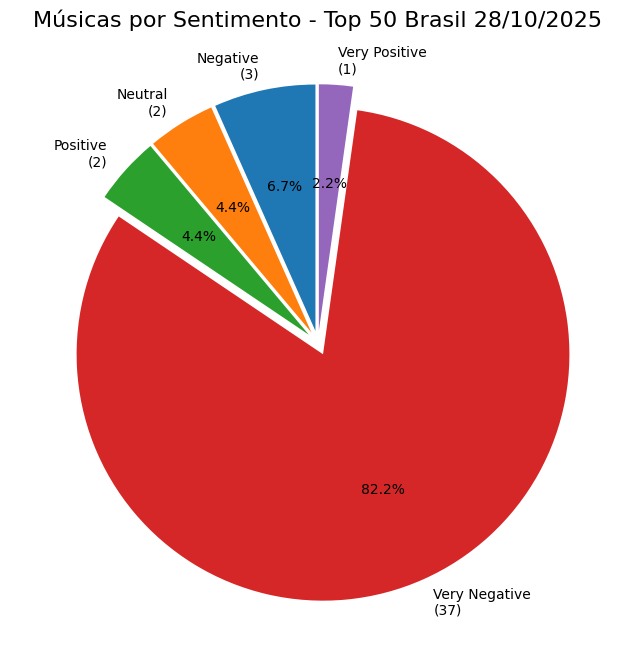

In [ ]:
df_playlist_sentimento = df_playlist_teste.groupby('sentimento_label')['id_musica'].size().reset_index(name='Quantidade')

labels_com_quantidade = [f'{label}\n({quant})' for label, quant in zip(df_playlist_sentimento['sentimento_label'], df_playlist_sentimento['Quantidade'])]

plt.figure(figsize=(10, 8))
plt.pie(
  df_playlist_sentimento['Quantidade'],
  labels=labels_com_quantidade,
  autopct='%1.1f%%',
  startangle=90,
  explode = [0.05] * len(df_playlist_sentimento)
)

plt.title('Músicas por Sentimento - Top 50 Brasil 28/10/2025', fontsize=16)
plt.show()

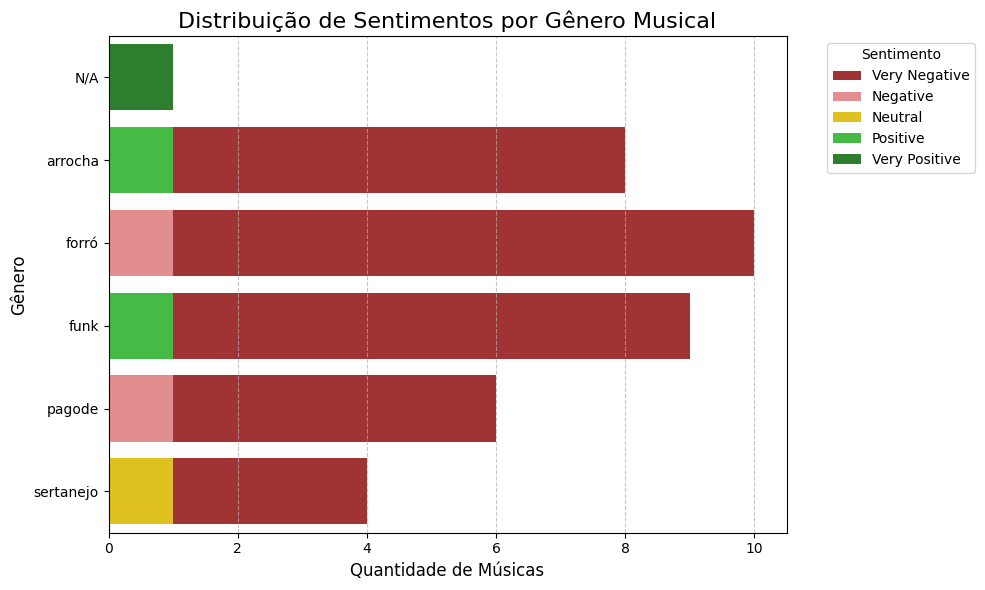

In [ ]:
df_sentimento_genero = df_playlist_teste.groupby(['genero_principal', 'sentimento_label']).size().unstack(fill_value=0)

sentimentos_ordenados = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']

for s in sentimentos_ordenados:
  if s not in df_sentimento_genero.columns:
    df_sentimento_genero[s] = 0

df_sentimento_genero = df_sentimento_genero[sentimentos_ordenados]

plt.figure(figsize=(10, 6))

df_plot = df_playlist_teste.groupby(['genero_principal', 'sentimento_label']).size().reset_index(name='count')

sns.barplot(
  data=df_plot,
  y='genero_principal',
  x='count',
  hue='sentimento_label',
  order=df_sentimento_genero.index,
  hue_order=df_sentimento_genero,
  palette = {
    'Very Negative': 'firebrick',
    'Negative': 'lightcoral',
    'Neutral': 'gold',
    'Positive': 'limegreen',
    'Very Positive': 'forestgreen'
  },
  dodge=False,
)


plt.title('Distribuição de Sentimentos por Gênero Musical', fontsize=16)
plt.xlabel('Quantidade de Músicas', fontsize=12)
plt.ylabel('Gênero', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Sentimento', bbox_to_anchor=(1.05, 1), loc='upper left') # Posiciona a legenda fora
plt.grid(axis='x', linestyle='--', alpha=0.7) # Grade no eixo X para facilitar a leitura dos valores

plt.tight_layout() # Ajusta o layout para não cortar elementos
plt.show()

In [ ]:
df_playlist_teste.query("genero_principal == 'N/A'")

,nome_musica,artistas,album,popularidade,id_musica,generos,artista_principal,nome_musica_limpo,genero_principal,letra,emocao_label,emocao_score,sentimento_label,sentimento_score
22,The Fate of Ophelia,Taylor Swift,The Life of a Showgirl,100,53iuhJlwXhSER5J2IYYv1W,N/A,Taylor Swift,The Fate of Ophelia,N/A,I heard you calling on the megaphone. You wann...,neutral,0.702579,Very Positive,0.669853


###Analise da Complexidade e Estrutura das Letras

In [ ]:
#Bibliotecas para análise de complexidade das letras
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
import string
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from legibilidad import legibilidad
import textstat

stopwords_pt = set(stopwords.words('portuguese'))
stopwords_en = set(stopwords.words('english'))

def analisar_letra(letra):
  """
  Função principal que detecta o idioma da letra e calcula todas as métricas.
  Retorna um dicionário com os resultados.
  """
  if not isinstance(letra, str) or len(letra.strip()) < 20:
    return {'idioma_detectado': 'nao_processado', 'riqueza_vocabular_ttr': 0.0,
            'comprimento_medio_frase': 0.0, 'indice_flesch': 0.0}

  # 1. Detecção do Idioma
  try:
    lang = detect(letra)
  except LangDetectException:
    lang = 'indefinido'

  # 2. Processamento baseado no idioma
  if lang == 'pt':
    tokens = preprocessar_texto(letra, stopwords_pt, 'portuguese')
    ttr = calcular_ttr(tokens)
    comp_frase = calcular_comprimento_medio_frase(letra, 'portuguese')

    try:
      # 1. Extrai as estatísticas do texto (palavras, sentenças, sílabas)
      stats = legibilidad.szigriszt_pazos(letra)
      # 2. Calcula o Flesch usando essas estatísticas
      flesch = legibilidad.inflesz(stats)
    except: # Adiciona um "try-except" para o caso de a função falhar em um texto
      flesch = 0.0

    return {'idioma_detectado': 'pt', 'riqueza_vocabular_ttr': ttr,
            'comprimento_medio_frase': comp_frase, 'indice_flesch': flesch}

  elif lang == 'en':
    tokens = preprocessar_texto(letra, stopwords_en, 'english')
    ttr = calcular_ttr(tokens)
    comp_frase = calcular_comprimento_medio_frase(letra, 'english')
    flesch = textstat.flesch_reading_ease(letra)
    return {'idioma_detectado': 'en', 'riqueza_vocabular_ttr': ttr,
            'comprimento_medio_frase': comp_frase, 'indice_flesch': flesch}

  else:
    return {'idioma_detectado': lang, 'riqueza_vocabular_ttr': 0.0,
            'comprimento_medio_frase': 0.0, 'indice_flesch': 0.0}


def preprocessar_texto(texto, stopwords_set, language):
  """Função genérica para limpar e tokenizar o texto."""
  texto = texto.lower()
  texto = texto.translate(str.maketrans('', '', string.punctuation))
  tokens = word_tokenize(texto, language=language)
  tokens_limpos = [palavra for palavra in tokens if palavra.isalpha() and palavra not in stopwords_set]
  return tokens_limpos

def calcular_ttr(tokens):
  """Calcula o Type-Token Ratio."""
  if len(tokens) == 0:
    return 0.0
  return len(set(tokens)) / len(tokens)

def calcular_comprimento_medio_frase(texto, language):
  """Calcula o número médio de palavras por frase."""
  frases = sent_tokenize(texto, language=language)
  if len(frases) == 0:
    return 0.0
  total_palavras = len(word_tokenize(texto, language=language))
  return total_palavras / len(frases)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
#df_playlist_teste['letra'] = df_playlist_teste['letra'].fillna('')
df_playlist_teste = pd.read_excel('df_playlist_teste.xlsx')

print("Iniciando análise multilíngue das letras... (Isso pode levar alguns minutos)")
# Aplica a função principal a cada letra e retorna um dicionário
analises = df_playlist_teste['letra'].apply(analisar_letra)

# Converte a série de dicionários em um novo DataFrame
df_analises = pd.json_normalize(analises)

# Junta o DataFrame original com o DataFrame das análises
df_resultado = pd.concat([df_playlist_teste, df_analises], axis=1)

# Salvar o resultado
#nome_arquivo_saida = 'analise_completa_letras_multilingue.csv'
#df_resultado.to_csv(nome_arquivo_saida, index=False, encoding='utf-8-sig')

condicao_para_eliminar = df_resultado['letra'].str.strip() == ''
df_resultado = df_resultado[~condicao_para_eliminar]

print("\n--- Análise Concluída! ---")
#print(f"Resultados salvos no arquivo: '{nome_arquivo_saida}'")
print("\nPré-visualização do resultado:")
df_resultado['indice_flesch'] = df_resultado['indice_flesch'].replace('muy fácil', 100)
df_resultado['indice_flesch'] = df_resultado['indice_flesch'].replace('bastante fácil', 100)
df_resultado.to_excel('df_resultado.xlsx', index=False)
display(df_resultado[['artista_principal', 'generos', 'nome_musica_limpo',
                      'emocao_label', 'emocao_score', 'sentimento_label', 'sentimento_score', 'riqueza_vocabular_ttr', 'comprimento_medio_frase', 'indice_flesch']])

Iniciando análise multilíngue das letras... (Isso pode levar alguns minutos)

--- Análise Concluída! ---

Pré-visualização do resultado:


/tmp/ipython-input-1789606707.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_resultado['indice_flesch'] = df_resultado['indice_flesch'].replace('muy fácil', 100)


,artista_principal,generos,nome_musica_limpo,emocao_label,emocao_score,sentimento_label,sentimento_score,riqueza_vocabular_ttr,comprimento_medio_frase,indice_flesch
0,DJ Japa NK,"brazilian funk, funk carioca, trap funk, funk ...",Posso Até Não Te Dar Flores,idioma_nao_suportado (pt),NaN,Very Negative,0.676148,0.310345,6.482143,100.000000
1,MC GP,"brazilian funk, trap funk, funk consciente",ME POSTOU NO DAILY,idioma_nao_suportado (pt),NaN,Very Negative,0.726864,0.525581,10.441860,100.000000
2,Grupo Menos É Mais,"piseiro, pagode, sertanejo, sertanejo universi...",P do Pecado,idioma_nao_suportado (pt),NaN,Very Negative,0.748585,0.260870,7.800000,100.000000
3,PEDRO SAMPAIO,"brazilian funk, brazilian phonk, brega funk, f...",SEQUÊNCIA FEITICEIRA,idioma_nao_suportado (pt),NaN,Positive,0.263463,0.452174,7.052632,100.000000
4,Vitinho Imperador,"piseiro, seresta, sertanejo, arrocha, forró, b...",Eu Me Apaixonei,idioma_nao_suportado (pt),NaN,Very Negative,0.569550,0.394444,7.210526,100.000000
5,Dj Caio Vieira,"brazilian funk, funk de bh, funk carioca",FAMOSINHA,idioma_nao_suportado (pt),NaN,Very Negative,0.648497,0.528497,7.442308,100.000000
6,Diego & Victor Hugo,"piseiro, sertanejo, sertanejo universitário, a...",Tubarões,idioma_nao_suportado (pt),NaN,Very Negative,0.819309,0.410526,6.382353,100.000000
7,Murilo Huff,"arrocha, sertanejo, sertanejo universitário, a...",Deixa Eu,idioma_nao_suportado (pt),NaN,Very Negative,0.718531,0.270968,7.976744,100.000000
8,Grupo Menos É Mais,"piseiro, pagode, seresta, sertanejo, arrocha, ...",Pela Última Vez,idioma_nao_suportado (pt),NaN,Very Negative,0.605680,0.273632,7.016129,100.000000
9,Rafa e Junior,"arrocha, sertanejo, sertanejo universitário, a...",Ama Um Maloqueiro,idioma_nao_suportado (pt),NaN,Very Negative,0.647201,0.289773,9.351351,100.000000


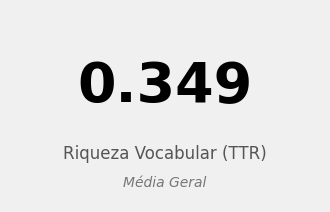

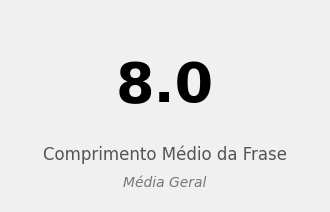

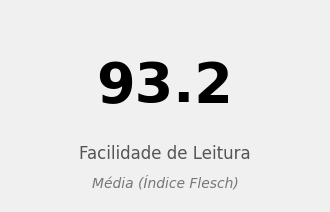

In [ ]:
analise_musicas = df_resultado[['riqueza_vocabular_ttr', 'comprimento_medio_frase', 'indice_flesch']].mean()

def create_kpi_card(value, title, subtitle, filename, color_value='#333333'):
  """
  Gera um card de KPI estilizado e o salva como uma imagem.

  Parâmetros:
  - value (str): O número principal a ser exibido.
  - title (str): O título/descrição do KPI.
  - subtitle (str): Um texto de contexto menor abaixo do título.
  - filename (str): O nome do arquivo de imagem a ser salvo (ex: 'meu_card.png').
  - color_value (str): A cor do texto do valor principal (opcional).
  """
  # Cria a "tela" do card com um tamanho específico
  fig, ax = plt.subplots(figsize=(4, 2.5))

  # Define a cor de fundo para o card
  fig.patch.set_facecolor('#f0f0f0')
  ax.set_facecolor('#f0f0f0')

  # Remove todas as bordas e marcações de eixos do gráfico padrão
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.tick_params(axis='both', which='both', length=0)
  ax.set_xticklabels([])
  ax.set_yticklabels([])

  # Adiciona o valor principal (número grande) no centro
  ax.text(0.5, 0.6, value, ha='center', va='center',
          fontsize=40, fontweight='bold', color=color_value)

  # Adiciona o título do KPI
  ax.text(0.5, 0.25, title, ha='center', va='center',
          fontsize=12, color='#555555')

  # Adiciona o subtítulo de contexto
  ax.text(0.5, 0.10, subtitle, ha='center', va='center',
          fontsize=10, fontstyle='italic', color='#777777')

  # Salva a figura final como uma imagem de alta resolução
  #plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
  plt.show()
  plt.close(fig) # Fecha a figura para liberar memória


# Card para Riqueza Vocabular (TTR)
create_kpi_card(
  f"{analise_musicas['riqueza_vocabular_ttr']:.3f}",
  "Riqueza Vocabular (TTR)",
  "Média Geral",
  "card_media_ttr.png",
  color_value='#000000'
)

# Card para Comprimento Médio da Frase
create_kpi_card(
  f"{analise_musicas['comprimento_medio_frase']:.1f}",
  "Comprimento Médio da Frase",
  "Média Geral",
  "card_media_comprimento.png",
  color_value='#000000'
)

# Card para Índice Flesch
create_kpi_card(
  f"{analise_musicas['indice_flesch']:.1f}",
  "Facilidade de Leitura",
  "Média (Índice Flesch)",
  "card_media_flesch.png",
  color_value='#000000'
)

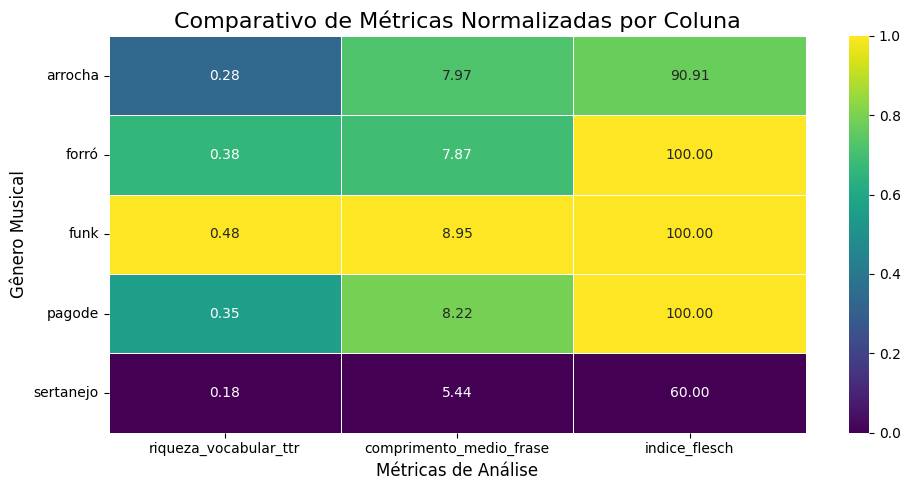

In [ ]:
from sklearn.preprocessing import MinMaxScaler

df_analise = df_resultado.groupby('genero_principal')[['riqueza_vocabular_ttr', 'comprimento_medio_frase', 'indice_flesch']].mean().reset_index()
df_analise = df_analise.set_index('genero_principal')

scaler = MinMaxScaler()
df_normalized = pd.DataFrame(
  scaler.fit_transform(df_analise),
  columns=df_analise.columns,
  index=df_analise.index
)

plt.figure(figsize=(10, 5)) # Define o tamanho da imagem

sns.heatmap(
  df_normalized,        # Dados para as cores (escala 0-1 por coluna)
  annot=df_analise,     # Dados para os números (valores originais)
  fmt=".2f",            # Formato dos números com 2 casas decimais
  cmap='viridis',       # Esquema de cores
  linewidths=.5,
  linecolor='white'
)

plt.title('Comparativo de Métricas Normalizadas por Coluna', fontsize=16)
plt.ylabel('Gênero Musical', fontsize=12)
plt.xlabel('Métricas de Análise', fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
#plt.savefig('heatmap_normalizado_por_coluna.png', dpi=300) # Salva com alta resolução
plt.show()

Índice Flesch quanto maior mais fácil a compreensão da letra

Comprimento Médio de palavras, quanto maior melhor

Riqueza Vocabular, quanto mais proximo de 1 maior a riqueza vocabular

###Analise dos Topicos das Musicas (Apenas Funciona com Playlists)

In [ ]:
!pip install gensim pyldavis

In [ ]:
#Bibliotecas para a analise de topicos abordados nas musicas
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

if 'tokens' not in df_resultado.columns:
  stopwords_pt = set(stopwords.words('portuguese'))
  stopwords_en = set(stopwords.words('english'))

  # Palavras ruidos
  stopwords_personalizadas = ['cê','vou','vai','faz','pro','pra']
  stopwords_pt.update(stopwords_personalizadas) # Adiciona as palavras customizadas à lista do inglês

  # Função para tokenizar
  def preprocessar_texto(texto, stopwords_set, language):
    texto = texto.lower()
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(texto, language=language)
    tokens_limpos = [palavra for palavra in tokens if palavra.isalpha() and palavra not in stopwords_set]
    return tokens_limpos

  df_resultado['tokens'] = df_resultado.apply(
      lambda row: preprocessar_texto(row['letra'], stopwords_pt if row['idioma_detectado'] == 'pt' else stopwords_en, 'portuguese' if row['idioma_detectado'] == 'pt' else 'english'), axis=1)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
df_portugues = df_resultado[df_resultado['idioma_detectado'] == 'pt']
df_ingles = df_resultado[df_resultado['idioma_detectado'] == 'en']

print("\n--- INICIANDO ANÁLISE DE TÓPICOS PARA MÚSICAS EM PORTUGUÊS ---")
tokens_pt = df_portugues[df_portugues['tokens'].str.len() > 15]['tokens'].tolist()
if len(tokens_pt) > 5:
  dicionario_pt = Dictionary(tokens_pt)
  corpus_pt = [dicionario_pt.doc2bow(letra) for letra in tokens_pt]
  modelo_lda_pt = LdaModel(corpus=corpus_pt, id2word=dicionario_pt, num_topics=5, passes=10, random_state=42)

  print("\n--- Tópicos em Português ---")
  for topic in modelo_lda_pt.print_topics(num_words=5): print(topic)

  vis_data_pt = gensimvis.prepare(modelo_lda_pt, corpus_pt, dicionario_pt)
  pyLDAvis.save_html(vis_data_pt, 'visualizacao_topicos_portugues.html')
  print("\nVisualização para português salva em 'visualizacao_topicos_portugues.html'")

print("\n--- INICIANDO ANÁLISE DE TÓPICOS PARA MÚSICAS EM INGLÊS ---")
tokens_en = df_ingles[df_ingles['tokens'].str.len() > 15]['tokens'].tolist()
if len(tokens_en) > 5:
  dicionario_en = Dictionary(tokens_en)
  corpus_en = [dicionario_en.doc2bow(letra) for letra in tokens_en]
  modelo_lda_en = LdaModel(corpus=corpus_en, id2word=dicionario_en, num_topics=5, passes=10, random_state=42)

  print("\n--- Tópicos em Inglês ---")
  for topic in modelo_lda_en.print_topics(num_words=5): print(topic)

  vis_data_en = gensimvis.prepare(modelo_lda_en, corpus_en, dicionario_en)
  pyLDAvis.save_html(vis_data_en, 'visualizacao_topicos_ingles.html')
  print("\nVisualização para inglês salva em 'visualizacao_topicos_ingles.html'")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


--- INICIANDO ANÁLISE DE TÓPICOS PARA MÚSICAS EM PORTUGUÊS ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


--- Tópicos em Português ---
(0, '0.016*"tava" + 0.015*"apaga" + 0.015*"senta" + 0.015*"side" + 0.013*"todo"')
(1, '0.024*"ai" + 0.013*"comigo" + 0.013*"amor" + 0.011*"vem" + 0.010*"quer"')
(2, '0.020*"vem" + 0.015*"amor" + 0.013*"choro" + 0.011*"boca" + 0.010*"ah"')
(3, '0.015*"tá" + 0.014*"yo" + 0.014*"alguém" + 0.014*"bem" + 0.013*"hoje"')
(4, '0.015*"volta" + 0.010*"desliza" + 0.010*"dá" + 0.010*"enfeiticei" + 0.010*"tá"')


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


Visualização para português salva em 'visualizacao_topicos_portugues.html'

--- INICIANDO ANÁLISE DE TÓPICOS PARA MÚSICAS EM INGLÊS ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag